# Optimization of Linear SVM Model on Dataset

## Import Data and Libraries

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gb
from gurobipy import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('/Users/chien/Library/CloudStorage/OneDrive-McGillUniversity/6d_MGSC695_Optimization/CleanedData.csv')

In [3]:
data.head()

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Approved_Conversion_Binary,gender_encoded,age_30-34,age_35-39,age_40-44,age_45-49
0,708746,916,103916,15,7350,1,1.43,2,1,1,1,1.0,0.0,0.0,0.0
1,708749,916,103917,16,17861,2,1.82,2,0,0,1,1.0,0.0,0.0,0.0
2,708771,916,103920,20,693,0,0.00,1,0,0,1,1.0,0.0,0.0,0.0
3,708815,916,103928,28,4259,1,1.25,1,0,0,1,1.0,0.0,0.0,0.0
4,708818,916,103928,28,4133,1,1.29,1,1,1,1,1.0,0.0,0.0,0.0


## Initialising the predictor and target variables

In [4]:
X = data.drop(['ad_id','xyz_campaign_id','fb_campaign_id','Approved_Conversion','Approved_Conversion_Binary'],axis=1)
y = data['Approved_Conversion_Binary']

In [5]:
X.head()

,interest,Impressions,Clicks,Spent,Total_Conversion,gender_encoded,age_30-34,age_35-39,age_40-44,age_45-49
0,15,7350,1,1.43,2,1,1.0,0.0,0.0,0.0
1,16,17861,2,1.82,2,1,1.0,0.0,0.0,0.0
2,20,693,0,0.00,1,1,1.0,0.0,0.0,0.0
3,28,4259,1,1.25,1,1,1.0,0.0,0.0,0.0
4,28,4133,1,1.29,1,1,1.0,0.0,0.0,0.0


In [6]:
# transform y from a series of 0 and 1 to -1 and 1
# 
y_transformed = [1 if yi == 1 else -1 for yi in y]

In [13]:
type(y_transformed)

list

## Building the Linear SVM Optimizer using a Linear Optimization Model

For a binary classifier problem, a support vector machine (SVM) finds the best separating hyperplane $\alpha^T x + \beta = 0$ using two supporting hyperplanes (one for each group), where $\alpha$ is the coefficient matrix and $\beta$ is the constant vector. 

Formulating the linear classification problem as such:

For $y_i = 1$: $\alpha^T x + \beta \geq 1$

Conversely, for $y_i = -1$: $\alpha^T x + \beta \leq 1$

The use of values 1 and -1 is equivalent to using $k$ and $-k$ as we may scale $\alpha$ and $\beta$.

Introducing two arbitrary vectors $x_1$ and $x_2$, where $x_1$ falls on the supporting hyperplane:  $\alpha^T x + \beta = 1$

and $x_2$ fall on the supporting hyperplane: $\alpha^T x + \beta = -1$

Maximizing the distance between the two supporting hyperplanes is equivalent to the projection of $x_1 - x_2$ onto the normal vector, $\alpha$. Therefore the length is:

$$ \frac {(x_1 - x_2)^T \alpha}{||\alpha||} $$

Given that $x_1$ and $x_2$ are supporting, $(x_1 - x_2)^T \alpha = 2 $ and therefore the length becomes: 

$$ \frac {2}{||\alpha||} $$

This form is equivalent to minimizing $ \frac {1}{2} ||\alpha||$ which is the same as minimizing $\frac{1}{2} \sum_{k=1}^{m} \alpha^2_i$.

Thereafter, the optimization problem can be re-evaluated as:

$$ \min \frac{1}{2} \sum_{k=1}^{m} \alpha^2_i $$

subject to: 

$$ y_i(\alpha^T x_i + \beta) \geq 1 \quad \forall i \in \{1, \ldots, n\} $$

### For imperfect separation

Introducing errors into objective function, the SVM problem then becomes: 

$$ \min \frac{1}{2} \sum_{k=1}^{m} \alpha^2_i + C\sum_{i=1}^{n} \gamma_i $$

subject to: 
$$ y_i(\alpha^T x_i + \beta) \geq 1 - \gamma_i \quad \forall i \in \{1, \ldots, n\} $$
$$ \gamma_i \geq 0 \quad \forall i \in \{1, \ldots, n\} $$

where $\gamma_i$ denotes the degree of violation (difference from a data point) and $C \geq 0 $ accounts for the penalty incurred with classification. 

In [7]:
num_features = X.shape[1]
num_samples = len(y_transformed)

# Create gb model
SVM = gb.Model("Linear Classifier")

# Decision Variables
alpha = SVM.addVars(num_features, vtype=gb.GRB.CONTINUOUS, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name=["weight {}".format(i) for i in range(num_features)])
bias = SVM.addVar(vtype=gb.GRB.CONTINUOUS, ub=gb.GRB.INFINITY, name="bias")
gamma = SVM.addVars(num_samples, lb=0, vtype=gb.GRB.CONTINUOUS, name="violation")
C = 1  # Regularization parameter

# Objective Function
objective = 0.5 * gb.quicksum(alpha[i]*alpha[i] for i in range(num_features)) + C * gb.quicksum(gamma[i] for i in range(num_samples))
SVM.setObjective(objective, gb.GRB.MINIMIZE)

# Constraints
for i in range(num_samples):
    SVM.addConstr(y_transformed[i] * (sum(alpha[j] * X.iloc[i, j] for j in range(num_features)) + bias) >= 1 - gamma[i])

# Optimize
SVM.optimize()

# Retrieve and print the solution
solution = {var.VarName: var.X for var in alpha.values()}
solution['bias'] = bias.X
print("Optimal solution:", solution)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-30
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1143 rows, 1154 columns and 9314 nonzeros
Model fingerprint: 0xadeff186
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 3e+06]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1143 rows, 1154 columns, 9314 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 11
 Free vars  : 10
 AA' NZ     : 8.171e+03
 Factor NZ  : 9.380e+03 (roughly 1 MB of memory)
 Factor Ops : 7.734e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                

## Confusion Matrix for Comparisons with Actual Data

Confusion Matrix:
 [[256 328]
 [ 51 508]]


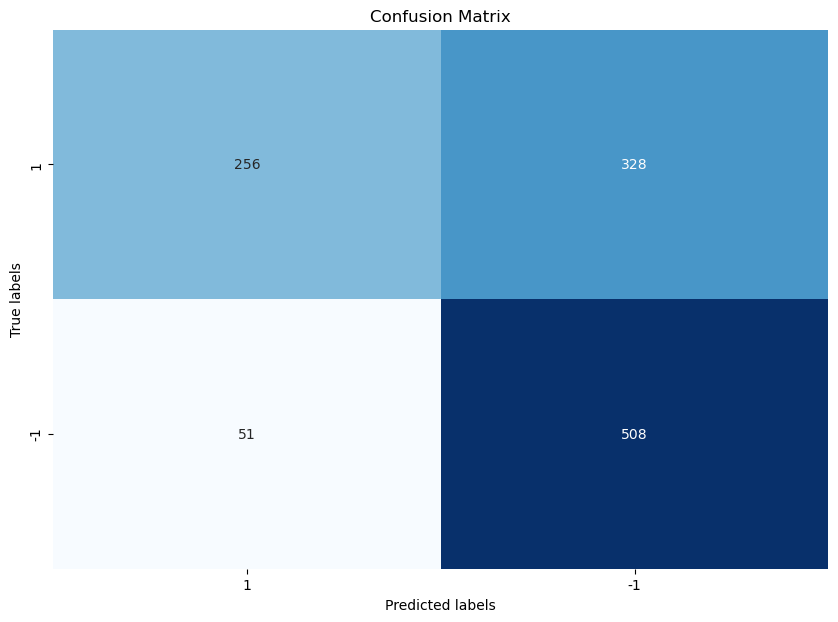

In [8]:
# Convert alpha to a numpy array for easier manipulation
alpha_values = np.array([alpha[i].X for i in range(num_features)])

# Compute predictions
predictions = []
for i in range(num_samples):
    decision_value = sum(alpha_values[j] * X.iloc[i, j] for j in range(num_features)) + bias.X
    predicted_class = 1 if decision_value >= 0 else -1
    predictions.append(predicted_class)

# Actual labels
actual_labels = y_transformed  # Assuming y_transformed is a numpy array or similar structure

# Construct confusion matrix
conf_matrix = confusion_matrix(actual_labels, predictions, labels=[1, -1])

# Print confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[1, -1], yticklabels=[1, -1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(actual_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6684


## Cross-Validation to determine best C (a form of hyperparameter)

In [16]:
from sklearn.model_selection import KFold
import numpy as np
import gurobipy as gb

# Assuming X, y_transformed, and other necessary libraries are already defined

# Define range of C values to test
C_values = [0.01, 0.1, 1, 10, 100]

# Initialize k-fold cross-validation
kf = KFold(n_splits=5)  # Example: 5-fold cross-validation

best_C = None
highest_accuracy = 0

all_accuracies = []  # To store mean accuracies for all C values

for C in C_values:
    accuracies = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        
        # Use list comprehension to index y_transformed when it's a list
        y_train = [y_transformed[i] for i in train_index]
        y_val = [y_transformed[i] for i in val_index]
        
        num_features = X_train.shape[1]
        num_samples = len(y_train)
        
        # Create gb model for current C
        SVM = gb.Model("Linear Classifier")
        
        # Suppress Gurobi output
        SVM.setParam('OutputFlag', 0)
        
        # Decision Variables
        alpha = SVM.addVars(num_features, vtype=gb.GRB.CONTINUOUS, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name=["weight {}".format(i) for i in range(num_features)])
        bias = SVM.addVar(vtype=gb.GRB.CONTINUOUS, ub=gb.GRB.INFINITY, name="bias")
        gamma = SVM.addVars(num_samples, lb=0, vtype=gb.GRB.CONTINUOUS, name="violation")
        
        # Objective Function
        objective = 0.5 * gb.quicksum(alpha[i]*alpha[i] for i in range(num_features)) + C * gb.quicksum(gamma[i] for i in range(num_samples))
        SVM.setObjective(objective, gb.GRB.MINIMIZE)
        
        # Constraints
        for i in range(num_samples):
            SVM.addConstr(y_train[i] * (sum(alpha[j] * X_train.iloc[i, j] for j in range(num_features)) + bias) >= 1 - gamma[i])
        
        # Optimize
        SVM.optimize()
        
        # Evaluate the model on validation set
        correct_predictions = 0
        for i in range(len(X_val)):
            prediction = sum(alpha[j].X * X_val.iloc[i, j] for j in range(num_features)) + bias.X
            if (prediction > 0 and y_val[i] == 1) or (prediction <= 0 and y_val[i] == -1):
                correct_predictions += 1
        accuracy = correct_predictions / len(X_val)
        accuracies.append(accuracy)
    
    # Compute average accuracy for this C and store
    avg_accuracy = np.mean(accuracies)
    all_accuracies.append((C, avg_accuracy))  # Store C and its mean accuracy
    
    if avg_accuracy > highest_accuracy:
        highest_accuracy = avg_accuracy
        best_C = C

print(f"Best C: {best_C} with highest accuracy: {highest_accuracy}")

# Print mean accuracy for each C
for C, avg_acc in all_accuracies:
    print(f"C = {C}: Mean Accuracy = {avg_acc}")

Best C: 0.1 with highest accuracy: 0.6754692407875584
C = 0.01: Mean Accuracy = 0.6369225465410251
C = 0.1: Mean Accuracy = 0.6754692407875584
C = 1: Mean Accuracy = 0.6684746801501571
C = 10: Mean Accuracy = 0.6684746801501571
C = 100: Mean Accuracy = 0.6684746801501571


**Extracted from ChatGPT:** 

The C value in the context of Support Vector Machines (SVM) and many other machine learning models acts as a regularization parameter. Specifically, in SVMs, C plays a crucial role in determining the trade-off between achieving a low training error and maintaining a low complexity of the model, which, in essence, affects the model's generalization to unseen data.

When C is small (C=0.1): The model increases the regularization strength, which encourages the model to be simpler, potentially at the cost of misclassifying more training examples. A smaller C value leads to a wider margin in SVM decision boundaries but allows more misclassifications. This can be beneficial for datasets with noisy observations and can help prevent overfitting, as it forces the model to focus on the broader trend rather than fitting to the noise.

When C is large: It signifies a lower regularization strength, prioritizing a lower training error, even if it means a more complex model boundary. A larger C tries to classify all training examples correctly, which might lead to a narrower margin if the data is linearly separable or not very noisy. However, this can make the model more sensitive to outliers and potentially lead to overfitting, especially if the data has a lot of noise or if the feature space is very high-dimensional.